# SGD Regression Model - Hyperparameter Tuning

## Strategy:
- Use ALL 4 features for maximum prediction accuracy
- Grid search hyperparameters: learning_rate, penalty, alpha, eta0
- Extensive visualization and analysis

In [ ]:
# Load preprocessing results from preprocessing.ipynb
%run preprocessing.ipynb
print("Preprocessing complete. Data ready for SGD modeling.")
print(f"Loaded variables: data, features, target, X_standardized")
print(f"Data shape: {data.shape}")
print(f"Features: {features}")
print(f"Target: {target}")

In [213]:
# Import all necessary libraries for SGD modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

CV_FOLDS = 10

print("SGD modeling libraries imported successfully.")
print(f"Random seed set to: {RANDOM_SEED}")
print(f"Cross-validation folds: {CV_FOLDS}")

SGD modeling libraries imported successfully.
Random seed set to: 42
Cross-validation folds: 10


In [214]:
param_grid = {
    'learning_rate': ['constant', 'optimal', 'adaptive'],
    'penalty': ['elasticnet', 'l1', 'l2'],
    'alpha': [0.0008, 0.001, 0.002, 0.005, 0.008, 0.01, 0.015, 0.02],
    'eta0': [0.0002, 0.0004, 0.0005, 0.001, 0.005, 0.01]
}

total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)
    print(f"{param}: {len(values)} options -> {values}")

total_experiments = total_combinations * CV_FOLDS
print(f"\n" + "="*60)
print(f"- Parameter combinations: {total_combinations}")
print(f"- Random 80/20 splits: {CV_FOLDS}")
print(f"- Total models to train: {total_experiments}")
print(f"="*60)

learning_rate: 3 options -> ['constant', 'optimal', 'adaptive']
penalty: 3 options -> ['elasticnet', 'l1', 'l2']
alpha: 8 options -> [0.0008, 0.001, 0.002, 0.005, 0.008, 0.01, 0.015, 0.02]
eta0: 6 options -> [0.0002, 0.0004, 0.0005, 0.001, 0.005, 0.01]

- Parameter combinations: 432
- Random 80/20 splits: 10
- Total models to train: 4320


In [215]:
print("\nStarting comprehensive SGD hyperparameter search...")
print(f"Total parameter combinations: {total_combinations}")
print(f"With {CV_FOLDS} random 80/20 splits: {total_combinations * CV_FOLDS} model fits")

cv = ShuffleSplit(n_splits=CV_FOLDS, test_size=0.2, random_state=RANDOM_SEED)

sgd = SGDRegressor(
    max_iter=300, 
    random_state=RANDOM_SEED, 
    early_stopping=True, 
    validation_fraction=0.2,
    n_iter_no_change=3,
    tol=1e-3
)

scoring = {
    'r2': 'r2',
    'rmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}


grid_search = GridSearchCV(
    estimator=sgd,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='r2',
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

print("\nTraining...")
start_time = time.time()
grid_search.fit(X_standardized, y)
end_time = time.time()

print(f"\nGrid search completed in {end_time - start_time:.1f} seconds")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation R² score: {grid_search.best_score_:.4f}")


Starting comprehensive SGD hyperparameter search...
Total parameter combinations: 432
With 10 random 80/20 splits: 4320 model fits

Training...
Fitting 10 folds for each of 432 candidates, totalling 4320 fits



Grid search completed in 46.4 seconds
Best parameters found: {'alpha': 0.0008, 'eta0': 0.005, 'learning_rate': 'adaptive', 'penalty': 'l1'}
Best cross-validation R² score: 0.9282


In [216]:
print("\n" + "="*60)
results_df = pd.DataFrame(grid_search.cv_results_)

print("Available columns in cv_results_:")
print([col for col in results_df.columns if 'test' in col])
print()

results_df['mean_test_rmse'] = np.sqrt(-results_df['mean_test_rmse'])
results_df['std_test_rmse'] = results_df['std_test_rmse'] / 2
results_df['mean_test_mae'] = -results_df['mean_test_mae']
results_df['std_test_mae'] = -results_df['std_test_mae']

results_df['mean_train_rmse'] = np.sqrt(-results_df['mean_train_rmse'])
results_df['mean_train_mae'] = -results_df['mean_train_mae']

# Calculate cross-validation consistency (coefficient of variation)
results_df['r2_cv_consistency'] = results_df['std_test_r2'] / results_df['mean_test_r2']
results_df['rmse_cv_consistency'] = results_df['std_test_rmse'] / results_df['mean_test_rmse']

print(f"Total parameter combinations tested: {len(results_df)}")
print(f"\nValidation R² Statistics:")
print(f"  Mean ± Std: {results_df['mean_test_r2'].mean():.4f} ± {results_df['mean_test_r2'].std():.4f}")
print(f"  Range: [{results_df['mean_test_r2'].min():.4f}, {results_df['mean_test_r2'].max():.4f}]")
print(f"\nValidation RMSE Statistics:")
print(f"  Mean ± Std: {results_df['mean_test_rmse'].mean():.2f} ± {results_df['mean_test_rmse'].std():.2f}")
print(f"  Range: [{results_df['mean_test_rmse'].min():.2f}, {results_df['mean_test_rmse'].max():.2f}]")
print(f"\nValidation MAE Statistics:")
print(f"  Mean ± Std: {results_df['mean_test_mae'].mean():.2f} ± {results_df['mean_test_mae'].std():.2f}")
print(f"  Range: [{results_df['mean_test_mae'].min():.2f}, {results_df['mean_test_mae'].max():.2f}]")

print("\n2. Individual parameter analysis:")

print("\n2.1 Learning Rate Analysis:")
lr_analysis = results_df.groupby('param_learning_rate').agg({
    'mean_test_r2': ['count', 'mean', 'std', 'min', 'max'],
    'mean_test_rmse': ['mean', 'std'],
    'mean_test_mae': ['mean', 'std'],
    'r2_cv_consistency': 'mean',
    'mean_fit_time': 'mean'
}).round(4)
print(lr_analysis)

print("\n2.2 Penalty Analysis:")
penalty_analysis = results_df.groupby('param_penalty').agg({
    'mean_test_r2': ['count', 'mean', 'std', 'min', 'max'],
    'mean_test_rmse': ['mean', 'std'],
    'mean_test_mae': ['mean', 'std'],
    'r2_cv_consistency': 'mean',
    'mean_fit_time': 'mean'
}).round(4)
print(penalty_analysis)

print("\n2.3 Alpha Analysis:")
alpha_analysis = results_df.groupby('param_alpha').agg({
    'mean_test_r2': ['count', 'mean', 'std', 'min', 'max'],
    'mean_test_rmse': ['mean', 'std'],
    'mean_test_mae': ['mean', 'std'],
    'r2_cv_consistency': 'mean',
    'mean_fit_time': 'mean'
}).round(4)
print(alpha_analysis)

print("\n2.4 Eta0 Analysis:")
eta0_analysis = results_df.groupby('param_eta0').agg({
    'mean_test_r2': ['count', 'mean', 'std', 'min', 'max'],
    'mean_test_rmse': ['mean', 'std'],
    'mean_test_mae': ['mean', 'std'],
    'r2_cv_consistency': 'mean',
    'mean_fit_time': 'mean'
}).round(4)
print(eta0_analysis)

print("\n3. Cross-validation consistency analysis:")
print("\nAll parameter combinations ranked by validation R² (top 20):")
top_performers = results_df.nlargest(20, 'mean_test_r2')[['params', 'mean_test_r2', 'std_test_r2', 
                                                         'mean_test_rmse', 'r2_cv_consistency', 'mean_fit_time']]
for idx, row in top_performers.iterrows():
    print(f"{idx+1:2d}. R²={row['mean_test_r2']:.4f}±{row['std_test_r2']:.4f} | "
          f"RMSE={row['mean_test_rmse']:.2f} | CV={row['r2_cv_consistency']:.4f} | "
          f"Time={row['mean_fit_time']:.2f}s | {row['params']}")

print("\nMost consistent parameter combinations (lowest CV, top 10):")
most_consistent = results_df.nsmallest(10, 'r2_cv_consistency')[['params', 'mean_test_r2', 'std_test_r2', 
                                                                 'r2_cv_consistency']]
for idx, row in most_consistent.iterrows():
    print(f"{idx+1:2d}. CV={row['r2_cv_consistency']:.4f} | R²={row['mean_test_r2']:.4f}±{row['std_test_r2']:.4f} | {row['params']}")

print("\n4. Parameter interaction analysis:")

# Create interaction matrices
interaction_data = results_df.copy()

print("\n4.1 Learning Rate × Penalty Interaction:")
lr_penalty = interaction_data.groupby(['param_learning_rate', 'param_penalty'])['mean_test_r2'].agg(['mean', 'std']).round(4)
print(lr_penalty)

print("\n4.2 Alpha × Eta0 Interaction:")
alpha_eta0 = interaction_data.groupby(['param_alpha', 'param_eta0'])['mean_test_r2'].agg(['mean', 'std']).round(4)
print(alpha_eta0)

print("\n4.3 Learning Rate × Alpha Interaction:")
lr_alpha = interaction_data.groupby(['param_learning_rate', 'param_alpha'])['mean_test_r2'].agg(['mean', 'std']).round(4)
print(lr_alpha)

# Training vs validation performance 
print("\n5. Overfitting analysis:")
results_df['overfitting'] = results_df['mean_train_r2'] - results_df['mean_test_r2']

overfitting_stats = results_df['overfitting'].describe()
print(f"\nOverall overfitting statistics (train R² - validation R²):")
print(f"  Mean overfitting: {overfitting_stats['mean']:.4f}")
print(f"  Std overfitting:  {overfitting_stats['std']:.4f}")
print(f"  Max overfitting:  {overfitting_stats['max']:.4f}")
print(f"  Min overfitting:  {overfitting_stats['min']:.4f}")

print(f"\n5.1 High-performing models with best generalization:")
print(f"(Filtering for R² > 0.925 to focus on competitive models)")
high_performers = results_df[results_df['mean_test_r2'] > 0.925]
print(f"High-performing models: {len(high_performers)} out of {len(results_df)}")

if len(high_performers) > 0:
    best_generalizers = high_performers.nsmallest(10, 'overfitting')[['params', 'mean_train_r2', 'mean_test_r2', 'overfitting', 'r2_cv_consistency']]
    print(f"\nBest generalizers among high performers (lowest overfitting):")
    for idx, row in best_generalizers.iterrows():
        print(f"{idx+1:2d}. Train R²={row['mean_train_r2']:.4f}, Val R²={row['mean_test_r2']:.4f}, "
              f"Gap={row['overfitting']:.4f}, CV={row['r2_cv_consistency']:.4f} | {row['params']}")
    
    # Show overfitting distribution for high performers
    hp_overfitting_stats = high_performers['overfitting'].describe()
    print(f"\nOverfitting statistics for high-performers (R² > 0.925):")
    print(f"  Mean overfitting: {hp_overfitting_stats['mean']:.4f}")
    print(f"  Std overfitting:  {hp_overfitting_stats['std']:.4f}")
    print(f"  Max overfitting:  {hp_overfitting_stats['max']:.4f}")
    print(f"  Min overfitting:  {hp_overfitting_stats['min']:.4f}")
else:
    print("No models achieved R² > 0.925")

print(f"\n5.2 Performance sensitivity analysis:")
print(f"Which hyperparameters cause the biggest performance variance?")

param_sensitivity = {}
for param in ['learning_rate', 'penalty', 'alpha', 'eta0']:
    param_column = f'param_{param}'
    if param_column in results_df.columns:
        param_std = results_df.groupby(param_column)['mean_test_r2'].std()
        param_range = results_df.groupby(param_column)['mean_test_r2'].apply(lambda x: x.max() - x.min())
        param_sensitivity[param] = {
            'max_std': param_std.max(),
            'mean_std': param_std.mean(),
            'max_range': param_range.max()
        }

print("Parameter sensitivity (higher = more impact on performance):")
for param, stats in param_sensitivity.items():
    print(f"  {param:15s}: Max Std={stats['max_std']:.4f}, Mean Std={stats['mean_std']:.4f}, Max Range={stats['max_range']:.4f}")

print(f"\n" + "="*60)
print(f"{len(results_df)} models analyzed")
print(f"Best overall R² score: {results_df['mean_test_r2'].max():.4f}")
print(f"Most consistent model CV: {results_df['r2_cv_consistency'].min():.4f}")
print(f"High performers (R² > 0.925): {len(high_performers) if 'high_performers' in locals() else 0}")
print(f"="*60)


Available columns in cv_results_:
['split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'split5_test_r2', 'split6_test_r2', 'split7_test_r2', 'split8_test_r2', 'split9_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2', 'split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse', 'split3_test_rmse', 'split4_test_rmse', 'split5_test_rmse', 'split6_test_rmse', 'split7_test_rmse', 'split8_test_rmse', 'split9_test_rmse', 'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae', 'split5_test_mae', 'split6_test_mae', 'split7_test_mae', 'split8_test_mae', 'split9_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae']

Total parameter combinations tested: 432

Validation R² Statistics:
  Mean ± Std: 0.9266 ± 0.0020
  Range: [0.9190, 0.9282]

Validation RMSE Statistics:
  Mean ± Std: 4.62 ± 0.06
  Range: [4.57, 4.85]

Validation MAE Statistics:
  Mean ± Std: 

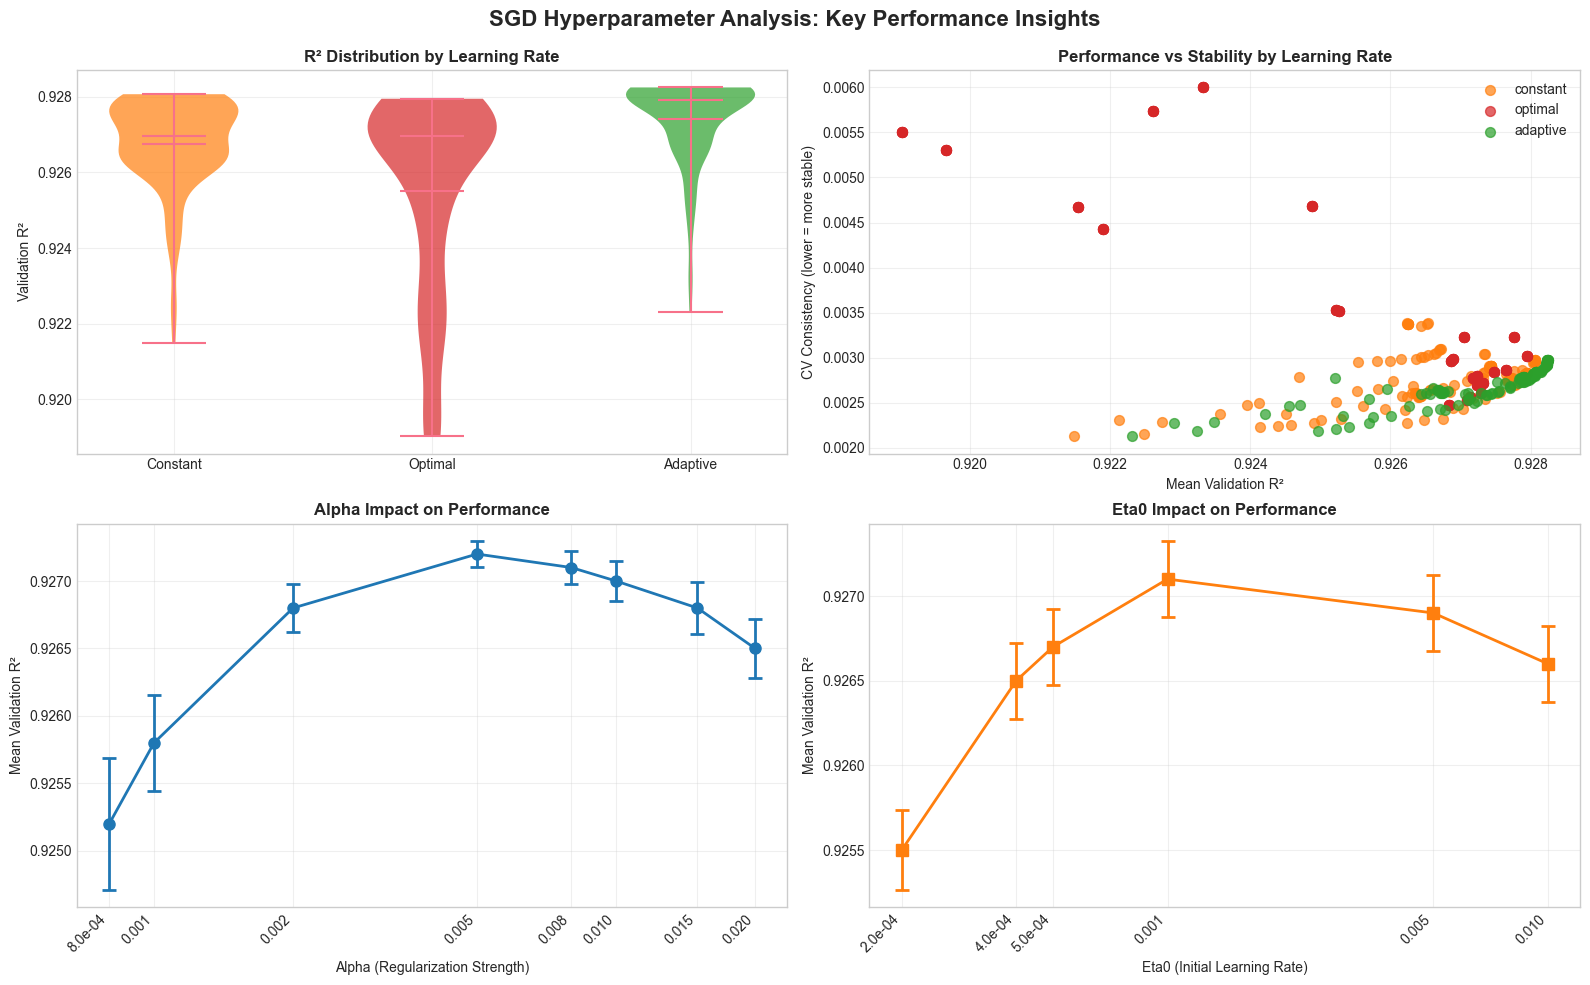

In [217]:

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: R² distribution by learning rate (violin plots)
lr_data = {}
for lr in ['constant', 'optimal', 'adaptive']:
    lr_data[lr] = results_df[results_df['param_learning_rate'] == lr]['mean_test_r2'].values

ax1 = axes[0,0]
positions = [1, 2, 3]
parts = ax1.violinplot([lr_data['constant'], lr_data['optimal'], lr_data['adaptive']], 
                       positions=positions, showmeans=True, showmedians=True)

colors = ['#ff7f0e', '#d62728', '#2ca02c']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax1.set_xticks(positions)
ax1.set_xticklabels(['Constant', 'Optimal', 'Adaptive'])
ax1.set_title('R² Distribution by Learning Rate', fontweight='bold')
ax1.set_ylabel('Validation R²')
ax1.grid(True, alpha=0.3)

# Plot 2: Performance vs Stability
ax2 = axes[0,1]
lr_colors = {'constant': '#ff7f0e', 'optimal': '#d62728', 'adaptive': '#2ca02c'}

for lr in ['constant', 'optimal', 'adaptive']:
    mask = results_df['param_learning_rate'] == lr
    ax2.scatter(results_df[mask]['mean_test_r2'], 
                results_df[mask]['r2_cv_consistency'], 
                label=lr, alpha=0.7, s=50, color=lr_colors[lr])

ax2.set_xlabel('Mean Validation R²')
ax2.set_ylabel('CV Consistency (lower = more stable)')
ax2.set_title('Performance vs Stability by Learning Rate', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Alpha impact
ax3 = axes[1,0]
alpha_performance = results_df.groupby('param_alpha').agg({
    'mean_test_r2': ['mean', 'std', 'count']
}).round(4)

alphas = alpha_performance.index
r2_means = alpha_performance[('mean_test_r2', 'mean')]
r2_stds = alpha_performance[('mean_test_r2', 'std')]
r2_counts = alpha_performance[('mean_test_r2', 'count')]

# Calculate standard error
r2_se = r2_stds / np.sqrt(r2_counts)

ax3.errorbar(alphas, r2_means, yerr=r2_se, marker='o', capsize=5, capthick=2, 
             linewidth=2, markersize=8, color='#1f77b4')
ax3.set_xlabel('Alpha (Regularization Strength)')
ax3.set_ylabel('Mean Validation R²')
ax3.set_title('Alpha Impact on Performance', fontweight='bold')
ax3.set_xscale('log')

ax3.set_xticks(alphas)
alpha_labels = [f'{x:.1e}' if x < 0.001 else f'{x:.3f}' for x in alphas]
ax3.set_xticklabels(alpha_labels, rotation=45, ha='right', fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Eta0 impact
ax4 = axes[1,1]
eta0_performance = results_df.groupby('param_eta0').agg({
    'mean_test_r2': ['mean', 'std', 'count']
}).round(4)

eta0s = eta0_performance.index
eta0_r2_means = eta0_performance[('mean_test_r2', 'mean')]
eta0_r2_stds = eta0_performance[('mean_test_r2', 'std')]
eta0_r2_counts = eta0_performance[('mean_test_r2', 'count')]

# Calculate standard error
eta0_r2_se = eta0_r2_stds / np.sqrt(eta0_r2_counts)

ax4.errorbar(eta0s, eta0_r2_means, yerr=eta0_r2_se, marker='s', capsize=5, capthick=2,
             linewidth=2, markersize=8, color='#ff7f0e')
ax4.set_xlabel('Eta0 (Initial Learning Rate)')
ax4.set_ylabel('Mean Validation R²')
ax4.set_title('Eta0 Impact on Performance', fontweight='bold')
ax4.set_xscale('log')

ax4.set_xticks(eta0s)
eta0_labels = [f'{x:.1e}' if x < 0.001 else f'{x:.3f}' for x in eta0s]
ax4.set_xticklabels(eta0_labels, rotation=45, ha='right', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('SGD Hyperparameter Analysis: Key Performance Insights', 
             fontsize=16, fontweight='bold', y=0.98)
plt.subplots_adjust(top=0.92)
plt.show()

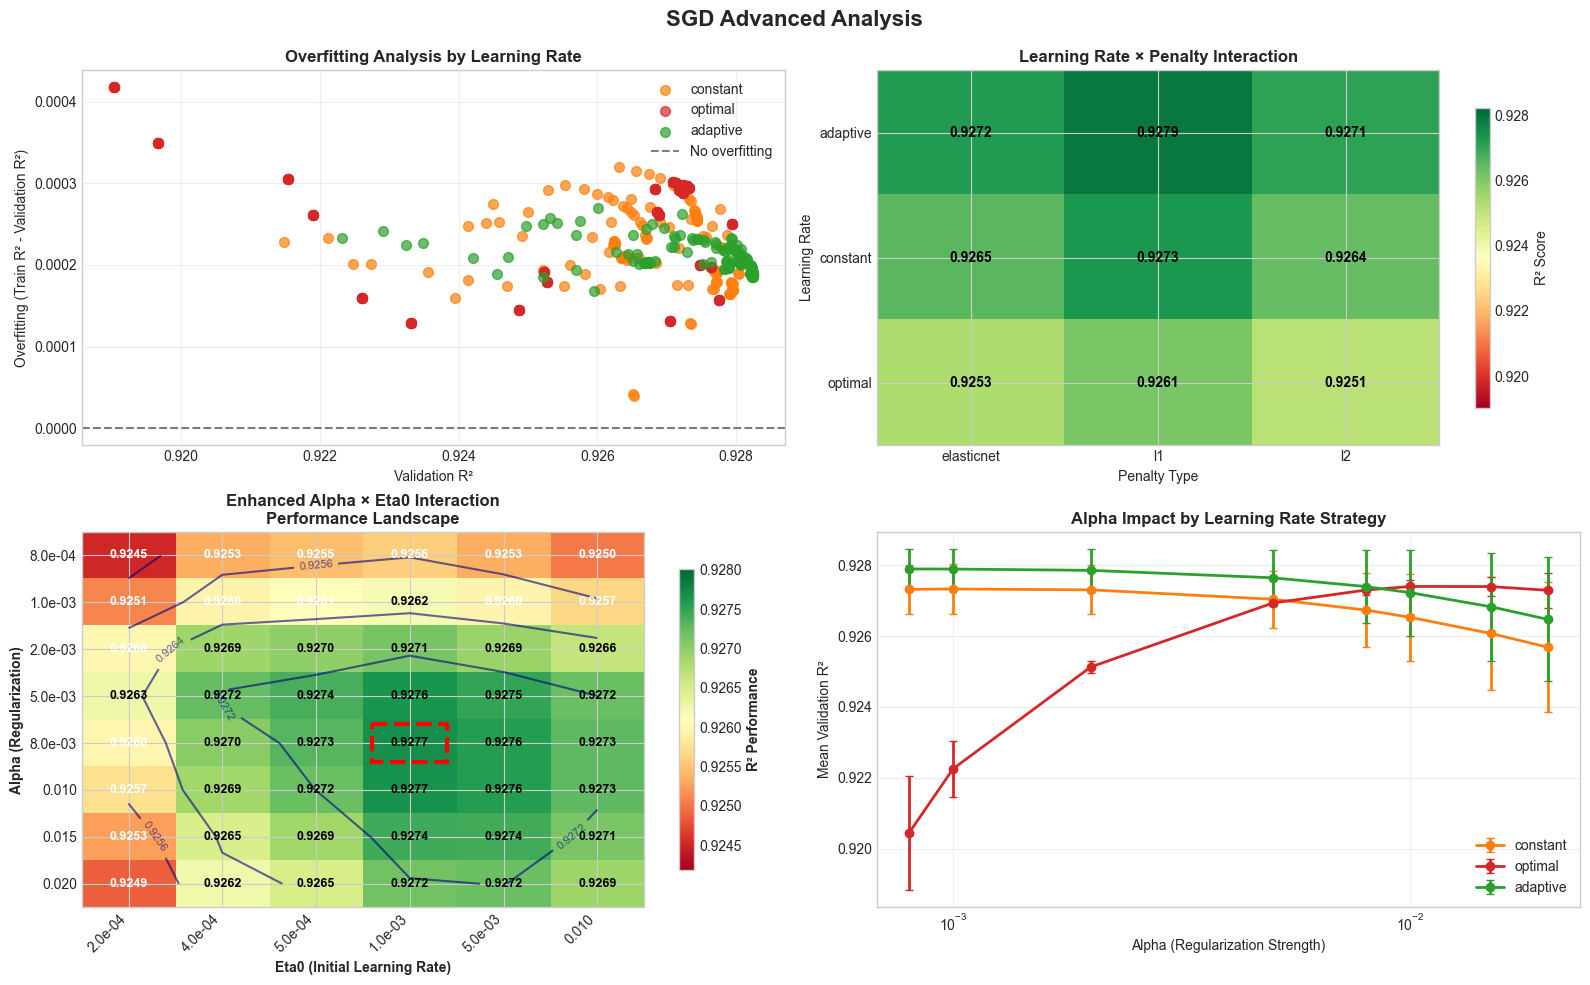

In [218]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Overfitting Analysis - Train vs Validation Performance
ax1 = axes[0,0]
train_val_diff = results_df['mean_train_r2'] - results_df['mean_test_r2']

# Create scatter plot colored by learning rate
lr_colors = {'constant': '#ff7f0e', 'optimal': '#d62728', 'adaptive': '#2ca02c'}
for lr in ['constant', 'optimal', 'adaptive']:
    mask = results_df['param_learning_rate'] == lr
    ax1.scatter(results_df[mask]['mean_test_r2'], 
                train_val_diff[mask], 
                label=lr, alpha=0.7, s=50, color=lr_colors[lr])

ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='No overfitting')
ax1.set_xlabel('Validation R²')
ax1.set_ylabel('Overfitting (Train R² - Validation R²)')
ax1.set_title('Overfitting Analysis by Learning Rate', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Learning Rate × Penalty Performance Matrix
ax2 = axes[0,1]
lr_penalty_pivot = results_df.pivot_table(values='mean_test_r2', 
                                          index='param_learning_rate', 
                                          columns='param_penalty', 
                                          aggfunc='mean')
im2 = ax2.imshow(lr_penalty_pivot.values, cmap='RdYlGn', aspect='auto',
                 vmin=results_df['mean_test_r2'].min(), vmax=results_df['mean_test_r2'].max())
ax2.set_xticks(range(len(lr_penalty_pivot.columns)))
ax2.set_yticks(range(len(lr_penalty_pivot.index)))
ax2.set_xticklabels(lr_penalty_pivot.columns)
ax2.set_yticklabels(lr_penalty_pivot.index)
ax2.set_xlabel('Penalty Type')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate × Penalty Interaction', fontweight='bold')

for i in range(len(lr_penalty_pivot.index)):
    for j in range(len(lr_penalty_pivot.columns)):
        text = ax2.text(j, i, f'{lr_penalty_pivot.values[i, j]:.4f}',
                       ha="center", va="center", color="black", fontweight='bold')

cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
cbar2.set_label('R² Score')

# Plot 3: Alpha × Eta0 Parameter Interaction Heatmap
ax3 = axes[1,0]

# Create enhanced pivot table with statistics
alpha_eta0_detailed = results_df.groupby(['param_alpha', 'param_eta0']).agg({
    'mean_test_r2': ['mean', 'std', 'count']
}).round(4)

# Pivot for mean values
alpha_eta0_pivot = results_df.pivot_table(values='mean_test_r2', 
                                          index='param_alpha', 
                                          columns='param_eta0', 
                                          aggfunc='mean')

# Enhanced color scaling - focus on actual data range with better contrast
data_min, data_max = alpha_eta0_pivot.values.min(), alpha_eta0_pivot.values.max()
data_range = data_max - data_min
vmin_enhanced = data_min - data_range * 0.1
vmax_enhanced = data_max + data_range * 0.1

# Create the heatmap with enhanced styling
im3 = ax3.imshow(alpha_eta0_pivot.values, cmap='RdYlGn', aspect='auto',
                 vmin=vmin_enhanced, vmax=vmax_enhanced)

ax3.set_xticks(range(len(alpha_eta0_pivot.columns)))
ax3.set_yticks(range(len(alpha_eta0_pivot.index)))

eta0_labels = [f'{x:.1e}' if x < 0.01 else f'{x:.3f}' for x in alpha_eta0_pivot.columns]
alpha_labels = [f'{x:.1e}' if x < 0.01 else f'{x:.3f}' for x in alpha_eta0_pivot.index]

ax3.set_xticklabels(eta0_labels, rotation=45, ha='right')
ax3.set_yticklabels(alpha_labels)
ax3.set_xlabel('Eta0 (Initial Learning Rate)', fontweight='bold')
ax3.set_ylabel('Alpha (Regularization)', fontweight='bold')
ax3.set_title('Enhanced Alpha × Eta0 Interaction\nPerformance Landscape', fontweight='bold')

for i in range(len(alpha_eta0_pivot.index)):
    for j in range(len(alpha_eta0_pivot.columns)):
        value = alpha_eta0_pivot.values[i, j]
        text_color = 'white' if value < (data_min + data_range * 0.5) else 'black'
        text = ax3.text(j, i, f'{value:.4f}', ha="center", va="center", 
                       color=text_color, fontweight='bold', fontsize=9)

X, Y = np.meshgrid(range(len(alpha_eta0_pivot.columns)), range(len(alpha_eta0_pivot.index)))
contours = ax3.contour(X, Y, alpha_eta0_pivot.values, levels=3, colors='navy', alpha=0.6, linewidths=1.5)
ax3.clabel(contours, inline=True, fontsize=8, fmt='%.4f')

cbar3 = plt.colorbar(im3, ax=ax3, shrink=0.8)
cbar3.set_label('R² Performance', fontweight='bold')

# Highlight optimal region with a box
optimal_alpha_idx = alpha_eta0_pivot.values.argmax() // len(alpha_eta0_pivot.columns)
optimal_eta0_idx = alpha_eta0_pivot.values.argmax() % len(alpha_eta0_pivot.columns)
rect = plt.Rectangle((optimal_eta0_idx-0.4, optimal_alpha_idx-0.4), 0.8, 0.8, 
                    fill=False, edgecolor='red', linewidth=3, linestyle='--')
ax3.add_patch(rect)

# Plot 4: Alpha × Learning Rate Detailed Interaction
ax4 = axes[1,1]
# Create a more detailed view of alpha effect by learning rate
for lr in ['constant', 'optimal', 'adaptive']:
    lr_data = results_df[results_df['param_learning_rate'] == lr]
    alpha_lr_stats = lr_data.groupby('param_alpha')['mean_test_r2'].agg(['mean', 'std'])
    
    ax4.errorbar(alpha_lr_stats.index, alpha_lr_stats['mean'], 
                yerr=alpha_lr_stats['std'], marker='o', capsize=3,
                label=lr, color=lr_colors[lr], linewidth=2, markersize=6)

ax4.set_xscale('log')
ax4.set_xlabel('Alpha (Regularization Strength)')
ax4.set_ylabel('Mean Validation R²')
ax4.set_title('Alpha Impact by Learning Rate Strategy', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('SGD Advanced Analysis', 
             fontsize=16, fontweight='bold', y=0.98)
plt.subplots_adjust(top=0.92)
plt.show()

In [219]:
print("\n" + "="*60)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation R² Score: {grid_search.best_score_:.4f}")

train_pred = best_model.predict(X_standardized)
train_r2 = r2_score(y, train_pred)
train_rmse = np.sqrt(mean_squared_error(y, train_pred))
train_mae = mean_absolute_error(y, train_pred)

print(f"\nFull Dataset Performance:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE: {train_mae:.2f}")

# Feature coefficients analysis
feature_names = features
coefficients = best_model.coef_
intercept = best_model.intercept_

print(f"\nModel Coefficients (on standardized features):")
print(f"  Intercept: {intercept[0]:.4f}")
for feature, coef in zip(feature_names, coefficients):
    print(f"  {feature:20s}: {coef:8.4f}")

# Calculate feature importance (absolute coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nFeature Importance (by absolute coefficient):")
for idx, row in feature_importance.iterrows():
    direction = "↑" if row['coefficient'] > 0 else "↓"
    print(f"  {row['feature']:20s}: {row['abs_coefficient']:6.4f} {direction}")

# Model convergence information
print(f"\nModel Convergence Information:")
print(f"  Iterations completed: {best_model.n_iter_}")
print(f"  Max iterations allowed: {best_model.max_iter}")
print(f"  Converged: {'Yes' if best_model.n_iter_ < best_model.max_iter else 'No'}")

# Residual analysis for the best model
residuals = y - train_pred
print(f"\nResidual Analysis:")
print(f"  Mean residual: {residuals.mean():.6f}")
print(f"  Std residual: {residuals.std():.4f}")
print(f"  Min residual: {residuals.min():.4f}")
print(f"  Max residual: {residuals.max():.4f}")

# Quick residual normality check
from scipy import stats
_, p_value = stats.shapiro(residuals.sample(min(5000, len(residuals))))
print(f"  Residual normality (Shapiro-Wilk p-value): {p_value:.2e}")
print(f"  Residuals appear {'normal' if p_value > 0.05 else 'non-normal'}")



Best Parameters: {'alpha': 0.0008, 'eta0': 0.005, 'learning_rate': 'adaptive', 'penalty': 'l1'}
Best Cross-Validation R² Score: 0.9282

Full Dataset Performance:
  R² Score: 0.9284
  RMSE: 4.56
  MAE: 3.62

Model Coefficients (on standardized features):
  Intercept: 454.3432
  ambient_temp        : -14.7118
  vacuum              :  -2.9788
  ambient_pressure    :   0.3724
  relative_humidity   :  -2.2905

Feature Importance (by absolute coefficient):
  ambient_temp        : 14.7118 ↓
  vacuum              : 2.9788 ↓
  relative_humidity   : 2.2905 ↓
  ambient_pressure    : 0.3724 ↑

Model Convergence Information:
  Iterations completed: 23
  Max iterations allowed: 300
  Converged: Yes

Residual Analysis:
  Mean residual: -0.007252
  Std residual: 4.5587
  Min residual: -43.4203
  Max residual: 17.7607
  Residual normality (Shapiro-Wilk p-value): 2.21e-30
  Residuals appear non-normal


In [ ]:
print("\n" + "="*60)

# Extract coefficient information for different alpha values
# We'll train individual models to get coefficient paths since GridSearchCV doesn't store them
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

print("Analyzing coefficient paths across regularization strengths...")
print("Training models with best hyperparameters at different alpha values...")

# Use best hyperparameters from grid search (except alpha which we'll vary)
best_params_fixed = {k: v for k, v in grid_search.best_params_.items() if k != 'alpha'}
print(f"Fixed parameters: {best_params_fixed}")

# Alpha values to analyze 
alpha_values = [0.0001, 0.0003, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]

# Storage for coefficient paths
coef_paths = {feature: [] for feature in features}
intercept_paths = []
alpha_used = []
performance_paths = []

print("\nTraining models across alpha values:")
for alpha in alpha_values:
    model = SGDRegressor(
        alpha=alpha,
        learning_rate=best_params_fixed['learning_rate'],
        penalty=best_params_fixed['penalty'],
        eta0=best_params_fixed['eta0'],
        max_iter=300,
        random_state=RANDOM_SEED,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=3,
        tol=1e-3
    )
    
    model.fit(X_standardized, y)
    
    for i, feature in enumerate(features):
        coef_paths[feature].append(model.coef_[i])
    intercept_paths.append(model.intercept_[0])
    alpha_used.append(alpha)
    
    pred = model.predict(X_standardized)
    r2 = r2_score(y, pred)
    performance_paths.append(r2)
    
    print(f"  α={alpha:6.4f}: R²={r2:.4f}, Converged: {'Yes' if model.n_iter_ < model.max_iter else 'No'}")

# Convert to arrays for easier plotting
coef_paths_array = np.array([coef_paths[feature] for feature in features])

print(f"\n6. Coefficient path insights:")

print(f"\n6.1 Analyze coefficient stability:")
for i, feature in enumerate(features):
    coef_values = coef_paths[feature]
    print(f"\n{feature}:")
    for j, alpha in enumerate(alpha_used):
        print(f"  α={alpha:6.4f}: coef={coef_values[j]:8.4f}")
    
    # Calculate when coefficient becomes negligible (< 0.1 in absolute value)
    negligible_threshold = 0.1
    negligible_alphas = [alpha_used[j] for j, coef in enumerate(coef_values) if abs(coef) < negligible_threshold]
    if negligible_alphas:
        print(f"  → Becomes negligible (|coef| < {negligible_threshold}) at α ≥ {min(negligible_alphas):.4f}")
    else:
        print(f"  → Never becomes negligible in tested range")

print(f"\n6.2 Performance vs regularization trade-off:")
print("α value    | R² Score | Performance Loss")
print("-" * 40)
best_r2 = max(performance_paths)
for i, (alpha, r2) in enumerate(zip(alpha_used, performance_paths)):
    loss = best_r2 - r2
    print(f"{alpha:8.4f} | {r2:.4f}   | {loss:.4f}")

best_alpha_idx = np.argmax(performance_paths)
optimal_alpha = alpha_used[best_alpha_idx]
optimal_r2 = performance_paths[best_alpha_idx]

print(f"\nOptimal regularization: α = {optimal_alpha:.4f} (R² = {optimal_r2:.4f})")

# Feature importance ranking at optimal alpha
print(f"\n6.3 Feature importance at optimal regularization (α = {optimal_alpha:.4f}):")
optimal_coefs = [(abs(coef_paths[feature][best_alpha_idx]), feature, coef_paths[feature][best_alpha_idx]) 
                 for feature in features]
optimal_coefs.sort(reverse=True)

for i, (abs_coef, feature, coef) in enumerate(optimal_coefs):
    direction = "↑" if coef > 0 else "↓"
    print(f"  {i+1}. {feature:20s}: {coef:8.4f} {direction} (|coef| = {abs_coef:.4f})")



Analyzing coefficient paths across regularization strengths...
Training models with best hyperparameters at different alpha values...
Fixed parameters: {'eta0': 0.005, 'learning_rate': 'adaptive', 'penalty': 'l1'}

Training models across alpha values:
  α=0.0001: R²=0.9284, Converged: Yes
  α=0.0003: R²=0.9284, Converged: Yes
  α=0.0005: R²=0.9284, Converged: Yes
  α=0.0010: R²=0.9284, Converged: Yes
  α=0.0020: R²=0.9284, Converged: Yes
  α=0.0050: R²=0.9284, Converged: Yes
  α=0.0100: R²=0.9284, Converged: Yes
  α=0.0200: R²=0.9284, Converged: Yes
  α=0.0500: R²=0.9284, Converged: Yes
  α=0.1000: R²=0.9283, Converged: Yes

6. Coefficient path insights:

6.1 Analyze coefficient stability:

ambient_temp:
  α=0.0001: coef=-14.7136
  α=0.0003: coef=-14.7131
  α=0.0005: coef=-14.7126
  α=0.0010: coef=-14.7112
  α=0.0020: coef=-14.7085
  α=0.0050: coef=-14.7005
  α=0.0100: coef=-14.6870
  α=0.0200: coef=-14.6600
  α=0.0500: coef=-14.5792
  α=0.1000: coef=-14.4444
  → Never becomes negligi